# Импорт необходимых библиотек

In [2]:
import pandas as pd
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import make_pipeline  


# 1. Подготовка к моделированию

## 1.1 Первичная очиска данных

In [24]:
# Загружаем данные в память
df_train = pd.read_csv('./data/train_oil.csv')
df_test = pd.read_csv('./data/oil_test.csv')

# Выводим первые 5 строк тренировочного датасета
len(df_test)

133

In [4]:
df_null = df_train.isna()
print(df_null.sum())
print('Из данного распределения видно, что в данных нет пропусков у числовых переменных, '+
      'следовательно, механизмы импутации не требуются')
print('Попробуем проверить, возможно ли заполнить пропуски с использованием имеющейся информации')
display(df_null.loc[df_null['Country'] == True])
print('Видно, что в пропусках по типу Страна отсутствуют и другие ее черты географии, '+
      'следовательно, заполнить пропуски не получится')
print('Проверим, находятся ли эти пропуски в минорных классах (определение минорных классов можно видеть в главе 1.2)')

Field name                         0
Reservoir unit                     0
Country                           27
Region                            38
Basin name                        38
Tectonic regime                    0
Latitude                          27
Longitude                         30
Operator company                   0
Onshore/Offshore                   0
Hydrocarbon type                   0
Reservoir status                   0
Structural setting                 0
Depth                              0
Reservoir period                   0
Lithology                          0
Thickness (gross average ft)       0
Thickness (net pay average ft)     0
Porosity                           0
Permeability                       0
dtype: int64
Из данного распределения видно, что в данных нет пропусков у числовых переменных, следовательно, механизмы импутации не требуются
Попробуем проверить, возможно ли заполнить пропуски с использованием имеющейся информации


,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Onshore/Offshore,Hydrocarbon type,Reservoir status,Structural setting,Depth,Reservoir period,Lithology,Thickness (gross average ft),Thickness (net pay average ft),Porosity,Permeability
11,False,False,True,True,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False
12,False,False,True,True,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False
15,False,False,True,True,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False
28,False,False,True,True,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False
33,False,False,True,True,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False
35,False,False,True,True,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False
37,False,False,True,True,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False
49,False,False,True,True,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False
50,False,False,True,True,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False
55,False,False,True,True,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False


Видно, что в пропусках по типу Страна отсутствуют и другие ее черты географии, следовательно, заполнить пропуски не получится
Проверим, находятся ли эти пропуски в минорных классах (определение минорных классов можно видеть в главе 1.2)


In [5]:
df_train.iloc[df_null.loc[df_null['Region'] == True].index]['Onshore/Offshore'].value_counts()
print('Из приведенного DataFrame видно, что распределение целевой переменной в пропусках '+
      'близко к тому, что содержится в основном датасете')
print('Вывод: пропуски могут быть удалены.')
df_train_preprocessed = df_train.dropna(how='any')
df_train_preprocessed.reset_index(drop=True, inplace=True)
print('Процент удаленных данных: ', (df_train.shape[0] - df_train_preprocessed.shape[0]) / df_train.shape[0]*100)

Из приведенного DataFrame видно, что распределение целевой переменной в пропусках близко к тому, что содержится в основном датасете
Вывод: пропуски могут быть удалены.
Процент удаленных данных:  13.268608414239482


In [6]:
print('Количество дубликатов в данных: ', df_train.duplicated().sum())

Количество дубликатов в данных:  0


## 1.2 Разведовательный анализ

### 1.2.1 Анализ категориальный переменных

In [7]:
# Подсчет значений для всех категориальных переменных
region_value_counts = df_train_preprocessed['Region'].value_counts()
target_value_counts = df_train_preprocessed['Onshore/Offshore'].value_counts()
basin_value_counts = df_train_preprocessed['Basin name'].value_counts()
tectonic_value_counts = df_train_preprocessed['Tectonic regime'].value_counts()
operator_value_counts = df_train_preprocessed['Operator company'].value_counts()
hydrocarbon_value_counts = df_train_preprocessed['Hydrocarbon type'].value_counts()  # Предполагаемое имя колонки
reservoir_status_value_counts = df_train_preprocessed['Reservoir status'].value_counts()
structural_value_counts = df_train_preprocessed['Structural setting'].value_counts()

# Анализ сбалансированности целевой переменной
y_plt = go.Figure(
        data=[
            go.Bar(
                x=target_value_counts.index,
                y=target_value_counts.values
            )
        ],
        layout=go.Layout(
            title='Распределение целевой переменной по классам',
            xaxis_title='Onshore/Offshore',
            yaxis_title='Количество скважин'
        )
    )
y_plt.show()

# Анализ категориальных переменных
# Регионы
region_plt = go.Figure(
        data=[
            go.Bar(
                x=region_value_counts.index,
                y=region_value_counts.values
            )
        ],
        layout=go.Layout(
            title='Распределение количества скважин по регионам',
            xaxis_title='Регион',
            yaxis_title='Количество скважин'
        )
    )
region_plt.show()

# Бассейны
basin_plt = go.Figure(
        data=[
            go.Bar(
                x=basin_value_counts.index,
                y=basin_value_counts.values
            )
        ],
        layout=go.Layout(
            title='Распределение количества скважин по бассейнам',
            title_subtitle={'text':'Для увеличения читабельности графика можно увеличить его части'},
            xaxis_title='Бассейн',
            yaxis_title='Количество скважин'
        )
    )
basin_plt.show()

# Тектонические режимы
tectonic_plt = go.Figure(
        data=[
            go.Bar(
                x=tectonic_value_counts.index,
                y=tectonic_value_counts.values
            )
        ],
        layout=go.Layout(
            title='Распределение количества скважин по тектоническим режимам',
            title_subtitle={'text':'Для увеличения читабельности графика можно увеличить его части'},
            xaxis_title='Тектонический режим',
            yaxis_title='Количество скважин'
        )
    )
tectonic_plt.show()

# Операторы
operator_plt = go.Figure(
        data=[
            go.Bar(
                x=operator_value_counts.index,
                y=operator_value_counts.values
            )
        ],
        layout=go.Layout(
            title='Распределение количества скважин по операторам',
            title_subtitle={'text':'Для увеличения читабельности графика можно увеличить его части'},
            xaxis_title='Наименование оператора',
            yaxis_title='Количество скважин'
        )
    )
operator_plt.show()

# Тип углеводорода
type_plt = go.Figure(
        data=[
            go.Bar(
                x=hydrocarbon_value_counts.index,
                y=hydrocarbon_value_counts.values
            )
        ],
        layout=go.Layout(
            title='Распределение количества скважин по типу углеводорода',
            title_subtitle={'text':'Для увеличения читабельности графика можно увеличить его части'},
            xaxis_title='Тип углеводорода',
            yaxis_title='Количество скважин'
        )
    )
type_plt.show()

# Cтатус месторождения
status_plt = go.Figure(
        data=[
            go.Bar(
                x=reservoir_status_value_counts.index,
                y=reservoir_status_value_counts.values
            )
        ],
        layout=go.Layout(
            title='Распределение количества скважин по статусу месторождения',
            title_subtitle={'text':'Для увеличения читабельности графика можно увеличить его части'},
            xaxis_title='Cтатус месторождения',
            yaxis_title='Количество скважин'
        )
    )
status_plt.show()

# Структурные свойства
structural_plt = go.Figure(
        data=[
            go.Bar(
                x=structural_value_counts.index,
                y=structural_value_counts.values
            )
        ],
        layout=go.Layout(
            title='Распределение количества скважин по структурным свойствам',
            title_subtitle={'text':'Для увеличения читабельности графика можно увеличить его части'},
            xaxis_title='Структурные свойства',
            yaxis_title='Количество скважин'
        )
    )
structural_plt.show()

Исходя из анализа, приведенного выше можно сделать следующие выводы:
1) Целевая переменная несбалансирована: количество скважин типа ONSHORE составляет 218 шт., а скважин типа OFFSHORE - 86 шт. Скважин смежного типа всего 5  шт.
2) Некоторые качественные переменные имеют слишком много возможных вариантов. В дальнейшем стоит объединить их в группу Others, возможно, это поможет в моделировании.

Проверим категориальные переменные на их связь с целевой переменной.
Учитывая, что целевая переменная является небинарной, то для проверки связи будем использовать **ANOVA**.

*Примечание:*

Для ANOVA необходимо, чтобы переменные были закодированы, поэтому закодируем их в этом блоке.

In [8]:
basin_value_counts.loc[basin_value_counts<=5].index

structural_value_counts.index

Index(['FORELAND', 'RIFT', 'INTRACRATONIC', 'THRUST', 'PASSIVE MARGIN',
       'SALT/FORELAND', 'SALT/PASSIVE MARGIN', 'DELTA/PASSIVE MARGIN',
       'INVERSION/RIFT', 'INVERSION/BACKARC', 'SALT/INVERSION/RIFT',
       'DELTA/SALT/PASSIVE MARGIN', 'THRUST/FORELAND', 'SUB-THRUST/FORELAND',
       'RIFT/SALT', 'BACKARC', 'RIFT/INVERSION', 'SUB-SALT/FORELAND',
       'SUB-SALT/RIFT', 'WRENCH', 'THRUST/SUB-THRUST/FORELAND',
       'FORELAND/THRUST', 'SALT/RIFT', 'FORELAND/SALT', 'SUB-THRUST',
       'WRENCH/DELTA', 'SUB-SALT/INVERSION', 'WRENCH/INVERSION/BACKARC',
       'SUB-SALT/PASSIVE MARGIN', 'WRENCH/PASSIVE MARGIN', 'INVERSION/FOREARC',
       'WRENCH/RIFT', 'FORELAND/PASSIVE MARGIN', 'WRENCH/FORELAND',
       'INVERSION/FORELAND', 'SUB-SALT', 'RIFT/PASSIVE MARGIN',
       'SALT/INVERSION/FORELAND', 'DELTA/FORELAND', 'DELTA/WRENCH',
       'INVERSION/WRENCH'],
      dtype='object', name='Structural setting')

In [9]:
# Когда я писал этот код не сразу подумал о цикле, а когда подумал, решил не переделывать
# Надеюсь, за это оценку не снизят)

df_train_labled = df_train_preprocessed.copy()
encoder = LabelEncoder()

# Объединяем все значения, которые встречаются менее 5 раз, в одну категорию
df_train_labled['Basin name_other'] = df_train_labled['Basin name']
df_train_labled.loc[df_train_labled['Basin name_other'].isin(basin_value_counts.loc[basin_value_counts<=5].index), 'Basin name other'] = 'Other'
df_train_labled['Tectonic regime_other'] = df_train_labled['Tectonic regime']
df_train_labled.loc[df_train_labled['Tectonic regime_other'].isin(tectonic_value_counts.loc[tectonic_value_counts<=5].index), 'Tectonic regime_other'] = 'Other'
df_train_labled['Operator company_other'] = df_train_labled['Operator company']
df_train_labled.loc[df_train_labled['Operator company_other'].isin(operator_value_counts.loc[operator_value_counts<=5].index), 'Operator company_other'] = 'Other'
df_train_labled['Structural setting_other'] = df_train_labled['Structural setting'] # Кажется, что объединить эту переменную можно как-то более изящно, но я пока не придумал, как именно)
df_train_labled.loc[df_train_labled['Structural setting_other'].isin(structural_value_counts.loc[structural_value_counts<=5].index), 'Structural setting_other'] = 'Other'

df_train_labled['Region'] = encoder.fit_transform(df_train_labled['Region'])
df_train_labled['Onshore/Offshore'] = encoder.fit_transform(df_train_labled['Onshore/Offshore'])
df_train_labled['Basin name']=encoder.fit_transform(df_train_labled['Basin name'])
df_train_labled['Basin name_other']=encoder.fit_transform(df_train_labled['Basin name other'])
df_train_labled['Tectonic regime']=encoder.fit_transform(df_train_labled['Tectonic regime'])
df_train_labled['Tectonic regime_other']=encoder.fit_transform(df_train_labled['Tectonic regime_other'])
df_train_labled['Operator company']=encoder.fit_transform(df_train_labled['Operator company'])
df_train_labled['Operator company_other']=encoder.fit_transform(df_train_labled['Operator company_other'])
df_train_labled['Hydrocarbon type']=encoder.fit_transform(df_train_labled['Hydrocarbon type'])
df_train_labled['Structural setting']=encoder.fit_transform(df_train_labled['Structural setting'])
df_train_labled['Structural setting_other']=encoder.fit_transform(df_train_labled['Structural setting_other'])
df_train_labled['Reservoir status']=encoder.fit_transform(df_train_labled['Reservoir status'])

In [10]:
categorical_columns = ['Region', 'Basin name', 'Basin name_other', 'Tectonic regime',
                       'Tectonic regime_other', 'Operator company', 'Operator company_other',
                       'Hydrocarbon type', 'Structural setting', 'Structural setting_other', 'Reservoir status']

f_stat_dict = {}
p_value_dict = {}

# Делаем ANOVA для каждой категориальной переменной с целевой
for i in categorical_columns:
    groups = [df_train_labled[df_train_labled[i] == cat]['Onshore/Offshore'] 
            for cat in df_train_labled[i].unique()]
    f_stat, p_value = f_oneway(*groups)
    f_stat_dict.update({i: f_stat})
    p_value_dict.update({i: p_value})
    
print(f_stat_dict)
print(p_value_dict)

print('Из сделанного теста ANOVA стало видно, что все категориальные переменные влияют на целевую переменную ' +
      'при этом группировка на уровне Other позволяет увеличить значение F-статистики (за исключением Basin name)')
print('Необходимо проверить, не попали ли в Other какие-то особые группы, которые были показаны выше, что может '+
      'повлиять на качество модели')

{'Region': np.float64(20.588309980750232), 'Basin name': np.float64(18.071870070438425), 'Basin name_other': np.float64(0.41061619171723107), 'Tectonic regime': np.float64(4.695071471008008), 'Tectonic regime_other': np.float64(10.385193830774424), 'Operator company': np.float64(2.1260884599268137), 'Operator company_other': np.float64(5.63554091725641), 'Hydrocarbon type': np.float64(2.4275595540582073), 'Structural setting': np.float64(6.409091689106716), 'Structural setting_other': np.float64(9.514689346905078), 'Reservoir status': np.float64(4.685736421680934)}
{'Region': np.float64(1.0138166000040069e-19), 'Basin name': np.float64(2.2811332268908726e-56), 'Basin name_other': np.float64(0.5222085742471818), 'Tectonic regime': np.float64(3.186719411500045e-16), 'Tectonic regime_other': np.float64(1.0437204071307607e-14), 'Operator company': np.float64(7.312448454842054e-06), 'Operator company_other': np.float64(4.059820199498322e-07), 'Hydrocarbon type': np.float64(0.065859498055669

In [11]:
basin_other_value_counts = df_train_preprocessed.loc[df_train_preprocessed['Basin name'].isin(
    basin_value_counts.loc[basin_value_counts<=5].index)]['Onshore/Offshore'].value_counts()
tectonic_other_value_counts = df_train_preprocessed.loc[df_train_preprocessed['Tectonic regime'].isin(
    tectonic_value_counts.loc[tectonic_value_counts<=5].index)]['Onshore/Offshore'].value_counts()
operator_other_value_counts = df_train_preprocessed.loc[df_train_preprocessed['Operator company'].isin(
    operator_value_counts.loc[operator_value_counts<=5].index)]['Onshore/Offshore'].value_counts()
structure_other_value_counts = df_train_preprocessed.loc[df_train_preprocessed['Structural setting'].isin(
    structural_value_counts.loc[structural_value_counts<=5].index)]['Onshore/Offshore'].value_counts()

basin_other_plt = go.Figure(
    data=[
        go.Bar(
            x=basin_other_value_counts.index,
            y=basin_other_value_counts.values
        )
    ],
    layout=go.Layout(
        title='Распределение Onshore/Offshore для редких бассейнов (≤5 скважин)',
        xaxis_title='Onshore/Offshore',
        yaxis_title='Количество скважин'
    )
)
basin_other_plt.show()

# Визуализация распределения целевой переменной для редких тектонических режимов
tectonic_other_plt = go.Figure(
    data=[
        go.Bar(
            x=tectonic_other_value_counts.index,
            y=tectonic_other_value_counts.values
        )
    ],
    layout=go.Layout(
        title='Распределение Onshore/Offshore для редких тектонических режимов (≤5 скважин)',
        xaxis_title='Onshore/Offshore',
        yaxis_title='Количество скважин'
    )
)
tectonic_other_plt.show()

# Визуализация распределения целевой переменной для редких операторов
operator_other_plt = go.Figure(
    data=[
        go.Bar(
            x=operator_other_value_counts.index,
            y=operator_other_value_counts.values
        )
    ],
    layout=go.Layout(
        title='Распределение Onshore/Offshore для редких операторов (≤5 скважин)',
        xaxis_title='Onshore/Offshore',
        yaxis_title='Количество скважин'
    )
)
operator_other_plt.show()

# Визуализация распределения целевой переменной для редких структурных свойств
structure_other_plt = go.Figure(
    data=[
        go.Bar(
            x=structure_other_value_counts.index,
            y=structure_other_value_counts.values
        )
    ],
    layout=go.Layout(
        title='Распределение Onshore/Offshore для редких структурных свойств (≤5 скважин)',
        xaxis_title='Onshore/Offshore',
        yaxis_title='Количество скважин'
    )
)
structure_other_plt.show()

Из графиков выше видно, что объединение по операторам является адекватным и правильным (увеличивает F-критерий, структура минорных признаков не меняется). Однако объединение для структурных свойств и тектонических режимов не так очевидно (увеличивает F-критерий, структура минорных признаков меняется). Объединение по бассейнам ухудшает F-критерий, следовательно от нее стоит отказаться.

Далее стоит проверить взаимосвязь нескольких категориальных признаков и целевой переменной. Для этого используем случайный лес.

In [12]:
# Сгруппируем по оператору в основном датасете
df_train_preprocessed.loc[df_train_preprocessed['Operator company'].isin(
    operator_value_counts.loc[operator_value_counts<=5].index), 'Operator company'] = 'Other'

X = df_train_preprocessed[['Region', 'Basin name', 'Tectonic regime', 'Operator company', 
                       'Hydrocarbon type', 'Structural setting', 'Reservoir status']]
X = pd.get_dummies(X)  

# Кодируем целевую переменную
y = encoder.fit_transform(df_train_preprocessed['Onshore/Offshore'])

# Обучаем модель
model = RandomForestClassifier()
model.fit(X, y)

# Важность признаков
importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importance.loc[importance>0.01])

Region_EUROPE                                      0.070890
Region_NORTH AMERICA                               0.047524
Basin name_NORTH SEA CENTRAL                       0.038106
Tectonic regime_EXTENSION/EROSION                  0.033292
Reservoir status_DEVELOPING                        0.032655
Structural setting_FORELAND                        0.030266
Tectonic regime_COMPRESSION                        0.028233
Structural setting_RIFT                            0.024295
Basin name_NORTH SEA NORTHERN                      0.023973
Tectonic regime_GRAVITY/EVAPORITE/COMPRESSION      0.021458
Reservoir status_PLATEAU PRODUCTION                0.020745
Region_AFRICA                                      0.018424
Structural setting_INTRACRATONIC                   0.016279
Basin name_GIPPSLAND                               0.013789
Basin name_JEANNE D ARC                            0.012856
Structural setting_INVERSION/RIFT                  0.012713
Region_FORMER SOVIET UNION              

Из случайного леса можно сделать следующие выводы:
1) 'Hydrocarbon type' нет в признаках, которые влияют на целевую переменную больше 1%. Добавляя к этому информацию по F-критерию можно предположить, что этот признак лучше не включать в модель, т. к. он не имеет значимости;
2) 'Operator company' присутствует лишь в 2 случаях, которые в совокупности влияют всего на 2,3%. Это может говорить о его низкой значимости, стоит это запомнить при моделировании.

**Выводы:**
1) Группировку осуществляем по переменной Operator company;
2) Hydrocarbon type исключам из категориальных переменных (строим модель без нее).

### 1.2.2 Анализ количественных переменных

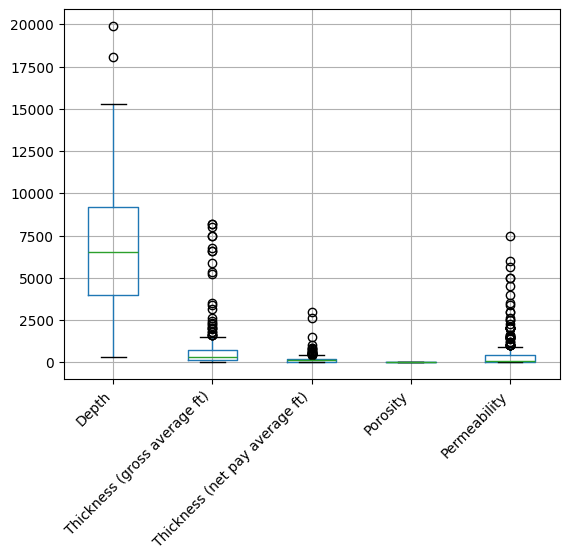

In [13]:
quantitative_columns =['Depth', 'Thickness (gross average ft)', 'Thickness (net pay average ft)',
                      'Porosity', 'Permeability']
# Сначала проверим на выбросы
df_train_preprocessed[quantitative_columns].boxplot()
plt.xticks(rotation=45, ha='right')
plt.show()


Из анализа выбросов можно сделать вывод, что они присутствуют в достаточно большом количестве в переменных 'Thickness (gross average ft)', 'Thickness (net pay average ft)', 'Permeability'. Следовательно, стоит это учитывать при моделировании (попробовать использовать пространство, отличное от Евклидового для KNN, использовать другие модели или исключить эти признаки)

In [14]:
f_stat_dict = {}
p_value_dict = {}

# Делаем ANOVA для каждой категориальной переменной с целевой
for i in quantitative_columns:
    groups = [df_train_labled[df_train_labled[i] == cat]['Onshore/Offshore'] 
            for cat in df_train_labled[i].unique()]
    f_stat, p_value = f_oneway(*groups)
    f_stat_dict.update({i: f_stat})
    p_value_dict.update({i: p_value})

print(f_stat_dict)
print(p_value_dict)

{'Depth': np.float64(1.690313990214853), 'Thickness (gross average ft)': np.float64(1.5293000940295665), 'Thickness (net pay average ft)': np.float64(1.1236711934636616), 'Porosity': np.float64(0.9649556878606974), 'Permeability': np.float64(1.0385895916577876)}
{'Depth': np.float64(0.05557791395460771), 'Thickness (gross average ft)': np.float64(0.008522040196867432), 'Thickness (net pay average ft)': np.float64(0.25447608666665605), 'Porosity': np.float64(0.5542695458645907), 'Permeability': np.float64(0.4142208951896218)}


Из анализа значимости можно сделать вывод, что переменная 'Thickness (gross average ft)' подходит для анализа, а остальные переменные не влияют на целевую переменную.

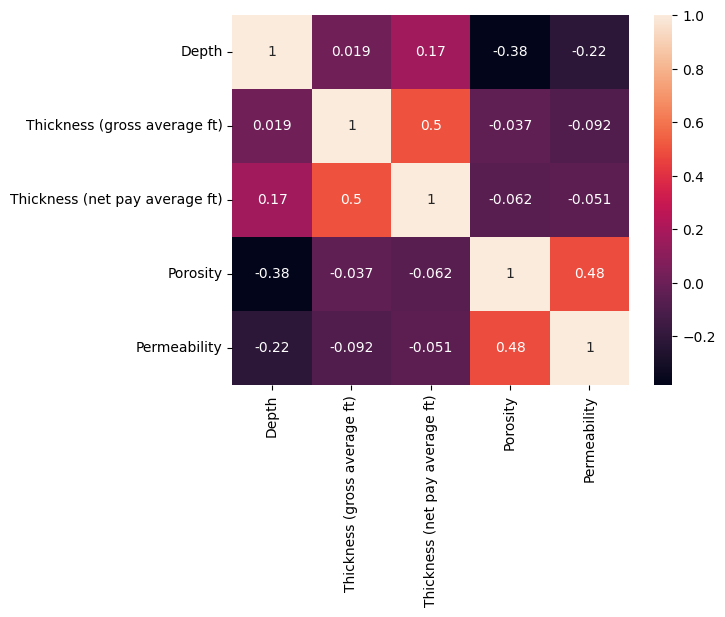

In [15]:
sns.heatmap(df_train_preprocessed[quantitative_columns].corr(), annot=True)
plt.show()

Из анализа мультиколлинеарности видно, что она присутствует. между Thickness (gross average ft) и Thickness (net pay average ft) и между Porosity и Permeability. Согласовываясь с F-критерием выбираем переменные Thickness (gross average ft) и Permeability

**Выводы:**
1) Выбросы в данных присутствуют;
2) Между количественными переменными и целевой переменной малые связи;
3) Присутствует мультиколлинеарность между переменными.

Т. к. разведовательный анализ закончен можно приступить к балансировке классов. Для этого воспользуемся методом SMOTE.

## 2. Моделирование

## 2.1 Моделирование KNN

In [16]:
numeric_features = ['Depth', 'Thickness (gross average ft)', 'Permeability']
categorical_features = ['Region', 'Basin name', 'Tectonic regime', 
                       'Operator company', 'Structural setting', 'Reservoir status']


X = df_train_preprocessed[numeric_features + categorical_features]
y = LabelEncoder().fit_transform(df_train_preprocessed['Onshore/Offshore'])

X = X.dropna()
y = y[X.index]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_resampled, y_train_resampled = RandomOverSampler(random_state=0).fit_resample(X_train, y_train)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

pipeline = make_pipeline(
    preprocessor,
    KNeighborsClassifier()
)

param_grid = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__metric': ['minkowski', 'euclidean', 'manhattan', 'l1', 'l2']
}

grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_macro')
grid.fit(X_train_resampled, y_train_resampled)

print(f"Лучшие параметры: {grid.best_params_}")
print(f"Лучшая точность: {grid.best_score_:.3f}")

Лучшие параметры: {'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__weights': 'distance'}
Лучшая точность: 0.948


In [17]:
pipeline_knn = make_pipeline(
    preprocessor,
    KNeighborsClassifier(metric='manhattan', weights='distance', n_neighbors=5)
)

pipeline_knn.fit(X_train_resampled, y_train_resampled)

y_pred = pipeline_knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# 2. Precision (по классам и усредненный)
precision_macro = precision_score(y_test, y_pred, average='macro')
precision_micro = precision_score(y_test, y_pred, average='micro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')

print(f"Precision Macro: {precision_macro:.4f}")
print(f"Precision Micro: {precision_micro:.4f}")
print(f"Precision Weighted: {precision_weighted:.4f}")

# 3. Recall (по классам и усредненный)
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_micro = recall_score(y_test, y_pred, average='micro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')

print(f"Recall Macro: {recall_macro:.4f}")
print(f"Recall Micro: {recall_micro:.4f}")
print(f"Recall Weighted: {recall_weighted:.4f}")

# 4. F1-score (по классам и усредненный)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"F1 Macro: {f1_macro:.4f}")
print(f"F1 Micro: {f1_micro:.4f}")
print(f"F1 Weighted: {f1_weighted:.4f}")


Accuracy: 0.8148
Precision Macro: 0.5212
Precision Micro: 0.8148
Precision Weighted: 0.8248
Recall Macro: 0.5339
Recall Micro: 0.8148
Recall Weighted: 0.8148
F1 Macro: 0.5265
F1 Micro: 0.8148
F1 Weighted: 0.8186


Из моделирования на основе KNN стало видно, что:
1) Расстояние 'manhattan' действительно лучше всех справляется с данной задачей (т. к. числовые данные содержат выбросы);
2) Из-за низкого количества данных для 'Onshore-Offshore' класса приходится использовать RandomOverSampler вместо SMOTE;
3) Классы все еще не сбалансированы.

## 2.2 Моделирование RandomForest

In [ ]:
numeric_features = ['Depth', 'Thickness (gross average ft)', 'Permeability']
categorical_features = ['Region', 'Basin name', 'Tectonic regime', 
                       'Operator company', 'Structural setting', 'Reservoir status']

label_encoder = LabelEncoder()

X = df_train_preprocessed[numeric_features + categorical_features]
y = label_encoder.fit_transform(df_train_preprocessed['Onshore/Offshore'])

X = X.dropna()
y = y[X.index]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_resampled, y_train_resampled = RandomOverSampler(random_state=0).fit_resample(X_train, y_train)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

pipeline = make_pipeline(
    preprocessor,
    RandomForestClassifier(random_state=0)
)

param_grid = {
    'randomforestclassifier__n_estimators': [50, 100, 200],
    'randomforestclassifier__max_depth': [None, 10, 20, 30],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
    'randomforestclassifier__max_features': ['sqrt', 'log2'],
    'randomforestclassifier__class_weight': [None, 'balanced']
}

grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_weighted')
grid.fit(X_train_resampled, y_train_resampled)

print(f"Лучшие параметры: {grid.best_params_}")
print(f"Лучшая точность: {grid.best_score_:.3f}")

Лучшие параметры: {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 30, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 100}
Лучшая точность: 0.966


In [19]:
pipeline_random_forest = make_pipeline(
    preprocessor,
    RandomForestClassifier(n_estimators=100, max_depth=30, min_samples_split=2, min_samples_leaf=1, max_features='log2', class_weight=None, random_state=0)
)

pipeline_random_forest.fit(X_train_resampled, y_train_resampled)

y_pred = pipeline_random_forest.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# 2. Precision (по классам и усредненный)
precision_macro = precision_score(y_test, y_pred, average='macro')
precision_micro = precision_score(y_test, y_pred, average='micro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')

print(f"Precision Macro: {precision_macro:.4f}")
print(f"Precision Micro: {precision_micro:.4f}")
print(f"Precision Weighted: {precision_weighted:.4f}")

# 3. Recall (по классам и усредненный)
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_micro = recall_score(y_test, y_pred, average='micro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')

print(f"Recall Macro: {recall_macro:.4f}")
print(f"Recall Micro: {recall_micro:.4f}")
print(f"Recall Weighted: {recall_weighted:.4f}")

# 4. F1-score (по классам и усредненный)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"F1 Macro: {f1_macro:.4f}")
print(f"F1 Micro: {f1_micro:.4f}")
print(f"F1 Weighted: {f1_weighted:.4f}")


Accuracy: 0.8519
Precision Macro: 0.5595
Precision Micro: 0.8519
Precision Weighted: 0.8328
Recall Macro: 0.5246
Recall Micro: 0.8519
Recall Weighted: 0.8519
F1 Macro: 0.5353
F1 Micro: 0.8519
F1 Weighted: 0.8352


C:\Users\raven\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\raven\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Т. к. оценки стали лучше от использования алгоритма случайного леса, то используем эту модель. По метрикам по прежнему вида несбалансированность классов, но будем надеятся, что это проблема этого классса.

# 3. Прогнозирование

In [28]:
X = df_train_preprocessed[numeric_features + categorical_features]
y = label_encoder.fit_transform(df_train_preprocessed['Onshore/Offshore'])

X = X.dropna()
y = y[X.index]

X_resampled, y_resampled = RandomOverSampler(random_state=0).fit_resample(X, y)


pipeline_random_forest = make_pipeline(
    preprocessor,
    RandomForestClassifier(n_estimators=100, max_depth=30, 
                           min_samples_split=2, min_samples_leaf=1, 
                           max_features='log2', class_weight=None, 
                           random_state=0)
)

pipeline_random_forest.fit(X_resampled, y_resampled)

y_pred = pipeline_random_forest.predict(X)

268 268


In [ ]:
df_test.loc[df_test['Operator company'].isin(operator_value_counts.loc[operator_value_counts<=5].index), 'Operator company'] = 'Other'

numeric_features = ['Depth', 'Thickness (gross average ft)', 'Permeability']
categorical_features = ['Region', 'Basin name', 'Tectonic regime', 
                       'Operator company', 'Structural setting', 'Reservoir status']


X_validate = df_test[numeric_features + categorical_features]

y_pred = pipeline_random_forest.predict(X_validate)

y_pred_inversed = label_encoder.inverse_transform(y_pred)
result = pd.DataFrame(y_pred_inversed, 
                      columns=['Onshore/Offshore'])['Onshore/Offshore'].map({'ONSHORE': 1, 
                                                         'OFFSHORE': 0, 
                                                         'ONSHORE-OFFSHORE': 2})

pd.DataFrame(result, columns=['Onshore/Offshore']).to_csv('data/oil_predictions.csv')


0      1
1      1
2      1
3      0
4      0
      ..
128    1
129    1
130    1
131    1
132    1
Name: Onshore/Offshore, Length: 133, dtype: int64
['ONSHORE' 'ONSHORE' 'ONSHORE' 'OFFSHORE' 'OFFSHORE' 'ONSHORE' 'ONSHORE'
 'OFFSHORE' 'ONSHORE' 'ONSHORE' 'ONSHORE' 'ONSHORE' 'OFFSHORE' 'OFFSHORE'
 'OFFSHORE' 'ONSHORE' 'ONSHORE' 'ONSHORE' 'OFFSHORE' 'ONSHORE' 'ONSHORE'
 'ONSHORE' 'ONSHORE' 'ONSHORE' 'OFFSHORE' 'OFFSHORE' 'OFFSHORE' 'ONSHORE'
 'OFFSHORE' 'OFFSHORE' 'ONSHORE' 'ONSHORE' 'ONSHORE' 'ONSHORE' 'ONSHORE'
 'OFFSHORE' 'ONSHORE' 'ONSHORE' 'ONSHORE' 'OFFSHORE' 'OFFSHORE' 'ONSHORE'
 'OFFSHORE' 'ONSHORE' 'OFFSHORE' 'ONSHORE' 'OFFSHORE' 'ONSHORE' 'ONSHORE'
 'ONSHORE' 'OFFSHORE' 'OFFSHORE' 'ONSHORE' 'ONSHORE' 'ONSHORE-OFFSHORE'
 'ONSHORE' 'ONSHORE' 'ONSHORE' 'ONSHORE' 'OFFSHORE' 'ONSHORE' 'ONSHORE'
 'OFFSHORE' 'ONSHORE' 'ONSHORE' 'ONSHORE' 'ONSHORE' 'ONSHORE' 'ONSHORE'
 'ONSHORE' 'ONSHORE' 'ONSHORE' 'OFFSHORE' 'ONSHORE' 'ONSHORE' 'ONSHORE'
 'ONSHORE' 'OFFSHORE' 'OFFSHORE' 'ONSHORE' 'ONSH

# 4. Результаты

![alt text](image.png)